# StatML Testat 3
## Maneuver Detection for Loft Dynamics Helicopter Simulation
Authors: Marcel Schubert, Florian Eugster, Nicola Dall'Acqua
#
#
#
#
#
#

### Imports

In [ ]:
import pandas as pd
import pyarrow          # Required for pandas read_parquet()
import os
import json
import seaborn as sb
import matplotlib.pyplot as plt

### 1. Reading, Splitting according to project documentation and visualizing data

In [ ]:
# Moving reserved data (as specified in project documentation) to test folder
# 6 out of 19 test flights were designated test data, i.e. ~31%
test_path = os.path.join('data', 'test')
if not os.path.exists(test_path):
    os.makedirs(test_path)
    
    files_to_move = [
        '0b3f3902-2c04-4625-8576-3bb963e3d709',
        '663f573a-74c5-4368-b60b-1fb433cd835d',
        '8c36586f-94e9-4ae9-8384-0f3342008677',
        'a376807a-82d3-4526-b19f-98d4b3f9078b',
        'd76bb0eb-bc08-4b35-8c1f-37369452083d',
        'f40f71de-5cc2-4719-8a5a-abcf950cbd71'
    ]
    
    for file_id in files_to_move:
        parquet_file = os.path.join('data', f'{file_id}.parquet')
        json_file = os.path.join('data', f'{file_id}.json')
        os.replace(parquet_file, os.path.join(test_path, f'{file_id}.parquet'))
        os.replace(json_file, os.path.join(test_path, f'{file_id}.json'))

# Preprocessing
Aufgrund der Datengrösse müssen die Preprocessing-Schritte auf den einzelnen Dateien ausgeführt werden

In [ ]:
def print_debug_information(df, memory_footprint=False):
    print("----------------------------------------------------------------------------------")
    print(f'Read {len(df.index)} rows and {len(df.columns)} columns of data')
    if memory_footprint:
        print(f'Total memory consumption is {df.memory_usage(deep=True).sum() / 1_000_000:.2f} MB')
    
    # Convert all category types to 'category' string for summary
    dtype_summary = df.dtypes.apply(lambda x: 'category' if x.name == 'category' else x).value_counts()
    print(f'Data type summary:\n{dtype_summary}')

    print(f'total missing values {df.isnull().sum().sum()}')
    print("----------------------------------------------------------------------------------")

# convert data types to default data types
def convert_datatypes(df, debug=False):
    if debug:
        print("converting values to default datatypes")

    original_dtypes = df.dtypes  # Store original dtypes for comparison
    df = df.convert_dtypes()  # Automatically convert columns to the best possible dtypes
    df = df.infer_objects() #tries converts object cols to something else
    new_dtypes = df.dtypes  # Store new dtypes for comparison
    if debug:
        changed_dtypes = original_dtypes[original_dtypes != new_dtypes]
        print(f'Changed {len(changed_dtypes)} dtypes')

    if debug:
        print("converting all object dt to string")
    # Convert all object datatypes to string
    original_dtypes = df.dtypes  # Store original dtypes for comparison
    df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})
    if debug:
        changed_dtypes = original_dtypes[original_dtypes != new_dtypes]
        print(f'Changed {len(changed_dtypes)} dtypes')

    if debug:
        print("converting all string dt to category")
    original_dtypes = df.dtypes  # Store original dtypes for comparison
    df = df.astype({col: 'category' for col in df.select_dtypes(include='string').columns})
    if debug:
        changed_dtypes = original_dtypes[original_dtypes != new_dtypes]
        print(f'Changed {len(changed_dtypes)} dtypes')
        
    if debug:
        print_debug_information(df)

    return df

def downcast_bools(df, debug=False):
    # Convert all boolean columns to uint8
    if debug:
        print('downcasting all bools to uint8')
    new_dtypes = df.dtypes
    original_dtypes = df.dtypes  # Store original dtypes for comparison
    df = df.astype({col: 'uint8' for col in df.select_dtypes(include='boolean').columns})
    if debug:
        changed_dtypes = original_dtypes[original_dtypes != new_dtypes]
        print(f'Changed {len(changed_dtypes)} dtypes')
        print_debug_information(df)
    return df

# remove all columns where values do not change
def remove_unchanging_columns(df, debug=False):
    if debug:
        print("removing all columns where values do not change")
    # Identify columns where all rows have the same value
    cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
    # Drop the identified columns
    df = df.drop(columns=cols_to_drop)
    if debug:
        print(f'deleted {len(cols_to_drop)} columns with identical row values')
        #print(cols_to_drop)
        print_debug_information(df)
    return df

def load_and_parse_column_mapping(col_map_path, debug=False):
    # load file that contains the mapping of stateId to string representation
    with open(col_map_path) as json_data:
        state_descriptions = json.load(json_data)
        if debug:
            print(f"Loaded column mapping from {col_map_path}")
            print(f"Number of state descriptions: {len(state_descriptions)}")

    # Create a map from stateId to column names
    state_id_to_col_name = {
        str(desc['stateId']): col_name for col_name, desc in state_descriptions.items()
    }
    if not len(state_descriptions) > 0:
        raise Exception("the column mapping map is empty")

    return state_id_to_col_name

def add_dependent_variable(df, annotations_path, name='maneuver', debug=False):
    # Convert the TimeStamp index to UTC if it is timezone naive
    timestamp_index = df.index.get_level_values('TimeStamp')
    if timestamp_index.dtype == 'datetime64[ns]':
        if debug:
            print('converting index TimeStamp to UTC')
        df.index = df.index.set_levels([timestamp_index.tz_localize('UTC')])

    # Load annotations
    with open(annotations_path) as json_file:
        annotations = json.load(json_file)
        if debug:
            print(f"Loaded annotations from {annotations_path}")
            print(f"Number of annotations (maneuvers): {len(annotations['annotations'])}")

    # Create the maneuver column and initialize it to None
    if debug:
        print('creating new col maneuver')
    df['maneuver'] = None  

    # Apply annotation labels based on the timestamp level in the MultiIndex
    for annotation in annotations['annotations']:
        start = pd.to_datetime(annotation['startTimestamp']).tz_localize('UTC')
        end = pd.to_datetime(annotation['endTimeStamp']).tz_localize('UTC')
        maneuver = annotation['comment']

        # Create a mask for the relevant MultiIndex level
        mask = (timestamp_index >= start) & (timestamp_index <= end)
        rows_affected = mask.sum()
        df.loc[mask, 'maneuver'] = maneuver  # Fill the maneuver column in bulk

        if debug:
            print(f'Set maneuver "{maneuver}" for {rows_affected} rows between {start} and {end}')
    
    #drop na values of maneuver
    na_filled_count = df['maneuver'].isna().sum()
    df['maneuver'] = df['maneuver'].fillna('no maneuver')
    if debug:
        print(f'Filled {na_filled_count} NaN maneuvers with "no maneuver"')
        print(f'converting maneuver to category')
    df['maneuver'] = df['maneuver'].astype('category')
    if debug:
        print(f'maneuver dtype is {df['maneuver'].dtype}')
    if df['maneuver'].dtype != 'category':
        print(f'WARNING, column maneuver is not of type category but {df['maneuver'].dtype}')
    return df

# MAIN PREPROCESSING FUNCTION
def preprocess_file(data_path, col_map_path, annotations_path, debug=False):
    # load parquet file and print information
    df = pd.read_parquet(data_path, engine='pyarrow')
    if debug:
        print(f'read file {data_path}')
        print_debug_information(df, memory_footprint=True)

    df = convert_datatypes(df, debug=debug)
    df = remove_unchanging_columns(df,debug=debug)

    # Forward fill NaN or None values
    if debug:
        print(f'filling in {df.isnull().sum().sum()} missing values with forward fill')
    df = df.ffill()
    if debug:
        print_debug_information(df)

    df = downcast_bools(df,debug=debug)

    # mapp the string representation of the col names
    # map column name from numeric representation to string
    if debug:
        print('renaming columns with json map')
    state_to_str_map = load_and_parse_column_mapping(col_map_path)
    df = df.rename(columns=lambda x: state_to_str_map.get(str(x), x))
    state_to_str_map = None

    df = add_dependent_variable(df, annotations_path, debug=debug)

    # Drop the 'TimeStamp' level from the MultiIndex
    if debug:
        print('deleting TimeStamp index')
    df.reset_index(level='TimeStamp', drop=True, inplace=True)

    if debug:
        print_debug_information(df, memory_footprint=True)
    return df

In [65]:
def create_maneuver_map(strings, path, debug=False):
    # Ensure the input is a list of strings
    if not isinstance(strings, list) or not all(isinstance(s, str) for s in strings):
        raise ValueError("Input must be a list of strings")
    
    # Check if the file already exists
    if os.path.exists(path):
        print(f"File {path} already exists.")
        return
    
    # Get unique strings and map them to uint8 values
    unique_strings = list(set(strings))
    if len(unique_strings) > 255:  # uint8 max value is 255
        raise ValueError("Too many unique strings to map to uint8")
    
    string_to_uint8 = {string: i for i, string in enumerate(unique_strings)}
    
    # Save the mapping to a JSON file
    with open(path, 'w') as json_file:
        json.dump(string_to_uint8, json_file)
    
    print(f"Mapping saved to {path}")

def read_maneuver_map(path, debug=False):
    # Ensure the path is a string
    if not isinstance(path, str):
        raise ValueError("Path must be a string")
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist")
    
    # Read the JSON file and return as a dictionary
    with open(path, 'r') as json_file:
        data = json.load(json_file)
    
    if debug:
        print(f"Read JSON from {path}: {data}")
    
    return data

def apply_maneuver_map(data, maneuver_map, column='maneuver', debug=False):
    # Ensure the column exists in the DataFrame
    if column not in data.columns:
        raise ValueError(f"Column {column} does not exist in the DataFrame")
    
    if data[column].dtype.name != 'category':
        raise Exception("maneuver is not of type category")
    
    if debug:
        print(f"Unique categories in column '{column}': {data[column].cat.categories.tolist()}")
        print('mapping maneuver strings to discrete integer')

    # Convert maneuver_map keys to lowercase for case-insensitive mapping
    maneuver_map_lower = {k.lower(): v for k, v in maneuver_map.items()}

    # Identify categories in the 'maneuver' column that do not have a corresponding mapping
    unmapped_categories = [category for category in data[column].cat.categories if category.lower() not in maneuver_map_lower]

    if unmapped_categories:
        raise Exception(f"Unmapped categories in column '{column}': {unmapped_categories}")

    if debug:
        print(f"All categories in column '{column}' have corresponding mappings.")

    original_dtype = data[column].dtype
    # Apply the mapping to the specified column
    data[column] = data[column].map(lambda x: maneuver_map_lower[x.lower()])

    if debug:
        print(f"Applied maneuver map to column {column}")
        new_dtype = data[column].dtype
        unique_values = data[column].unique()
        print(f"Original dtype of column '{column}': {original_dtype}")
        print(f"New dtype of column '{column}': {new_dtype}")
        print(f"Unique int values in column '{column}': {unique_values}")
        print(f"-----------------------------------------------------------------")

    if data[column].dtype.name != 'category' and data[column].dtype != 'int':
        raise TypeError(f"Column {column} is of wrong type")
    
    return data

In [ ]:
# applies rolling window on maneuver dataframe
# beware of scaling since it iterates over the whole dataset with the window size
# currently only means the numeric values and makes majority vote on the maneuver
def rolling_window_df(df, window=10_000, default_maneuver='no maneuver'):
    # Validate that the window parameter is an integer
    if not isinstance(window, int):
        raise ValueError("window must be an integer")
    
    # Ensure window does not exceed the size of the DataFrame
    if window > len(df):
        raise ValueError("window size must not be greater than the number of rows in the DataFrame")

    # Select numeric columns excluding 'maneuver'
    numeric_cols = df.select_dtypes(include='number').columns.difference(['maneuver'], sort=False)

    # Apply a rolling mean to numeric columns if there are any
    if not numeric_cols.empty:
        df[numeric_cols] = df[numeric_cols].rolling(window=window, min_periods=window).mean()  # Calculate rolling mean
    else:
        raise Exception("no numeric cols found")

      # Check if the 'maneuver' column exists before processing
    if 'maneuver' in df.columns:
        # Store the categories of the maneuver column
        maneuver_categories = df['maneuver'].cat.categories
        
        # Create a copy of the maneuver column as codes
        maneuver_codes = df['maneuver'].cat.codes

        # Apply rolling window with majority vote
        rolled_modes = pd.Series(maneuver_codes).rolling(window=window, min_periods=1).apply(
            lambda x: x.mode()[0] if not x.mode().empty else default_maneuver, 
            raw=False
        )
        # Convert back to categorical using the stored categories
        df['maneuver'] = pd.Categorical.from_codes(rolled_modes.astype('int'), categories=maneuver_categories)
    else:
        raise Exception("there is no dependent variable with name maneuver")
    
    return df


## Preprocessing all parquet files serially then caching them to files (pickle)

## Single File Test
This shows how to preprocess a single parquet file.
Reads into a pandas df. Preprocesses it. Maps the Maneuver.
Saves it into the pickle format for retaining the datatypes.

In [ ]:
os.makedirs('parsed_data', exist_ok=True)  
create_maneuver_map(
    ["Hover", "Climb", "Straight and level", "Left turn", "Right turn", "Descent", "Hover", "no maneuver", "Autorotation"],
    "parsed_data/maneuver_map.json"
)
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
df=None
df = preprocess_file(
        os.path.join('data', '28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.parquet'),
        os.path.join('data', 'StateDescriptions.json'),
        os.path.join('data', '28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.json'),
        debug=True
    )


File parsed_data/maneuver_map.json already exists.
Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}
read file data/28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.parquet
----------------------------------------------------------------------------------
Read 291774 rows and 1031 columns of data
Total memory consumption is 4825.41 MB
Data type summary:
float64    534
object     497
Name: count, dtype: int64
total missing values 293740780
----------------------------------------------------------------------------------
converting values to default datatypes
Changed 994 dtypes
converting all object dt to string
Changed 0 dtypes
converting all string dt to category
Changed 37 dtypes
----------------------------------------------------------------------------------
Read 291774 rows and 1031 columns of data
Data type summary:
Int64       452
boolean     451
Float64      82

In [61]:
df = apply_maneuver_map(df, maneuver_map, debug=True)
df.to_pickle('parsed_data/28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.pkl')

Unique categories in column 'maneuver': ['Autorotation', 'Climb', 'Descent', 'Hover', 'Left turn', 'Right turn', 'Straight and level', 'no maneuver']
mapping maneuver strings to discrete integer
All categories in column 'maneuver' have corresponding mappings.
Applied maneuver map to column maneuver
Original dtype of column 'maneuver': category
New dtype of column 'maneuver': category
Unique int values in column 'maneuver': [4, 0, 3, 2, 1, 6, 5, 7]
Categories (8, int64): [7, 3, 5, 0, 1, 6, 2, 4]


## Process All Files
This processes all parquet files in the data directory into preprocessed pickle files in the target directory parsed_data.

In [67]:
# this will preprocess all parquet files into a usable format.
# all numeric types are retained.
# bools are cast to uint8
# object are infered automatically
# if its not automatically infered it is set as type string
# string types are then casted to the categorical type
# all columns that do have static values are dropped

# the parsed files are written to pickle file in the target directory
# for further usage the parsed data can be loaded using pd.read_pickle(path)
os.makedirs('parsed_data', exist_ok=True)  
create_maneuver_map(
    ["Hover", "Climb", "Straight and Level", "Left Turn", "Right Turn", "Descent", "Hover", "no maneuver"],
    "parsed_data/maneuver_map.json"
)
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json",debug=True)
# Iterate over all .parquet files in the 'data' folder
for file in os.listdir('data'):
    if file.endswith('.parquet'):
        file_base = os.path.splitext(file)[0]
        pkl_path = os.path.join('parsed_data', f'{file_base}.pkl')
        
        # Skip processing if the pickle file already exists
        if os.path.exists(pkl_path):
            print(f"Pickle file {pkl_path} already exists. Skipping processing.")
            continue
        
        df = None
        parquet_path = os.path.join('data', file)
        json_path = os.path.join('data', f'{file_base}.json')
        
        # Preprocess the file
        df = preprocess_file(parquet_path, os.path.join('data', 'StateDescriptions.json'), json_path, debug=True)
        df = apply_maneuver_map(df, maneuver_map, debug=True)
        
        # Save the preprocessed DataFrame to a pickle file
        df.to_pickle(pkl_path)

File parsed_data/maneuver_map.json already exists.
Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}
Pickle file parsed_data/28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.pkl already exists. Skipping processing.
Pickle file parsed_data/8ac99efe-b70b-4b4b-983b-6064fe37c67b.pkl already exists. Skipping processing.
read file data/39b2c145-c49f-470b-8280-d253fa98153f.parquet
----------------------------------------------------------------------------------
Read 331620 rows and 1037 columns of data
Total memory consumption is 5519.33 MB
Data type summary:
float64    537
object     500
Name: count, dtype: int64
total missing values 335354114
----------------------------------------------------------------------------------
converting values to default datatypes
Changed 1000 dtypes
converting all object dt to string
Changed 0 dtypes
converting all string dt to category
Chan

# Preprocessing Analysis

In [128]:
# Initialize an empty DataFrame to store preprocessing metrics
preprocessing_metrics_df = pd.DataFrame(columns=[
    'file_base', 'original_memory', 'parsed_memory', 'original_columns', 'parsed_columns', 'memory_ratio', 'columns_ratio'
])

# List to collect the new rows
rows = []

In [129]:
# Iterate over all .parquet files in the 'data' folder
for file in os.listdir('data'):
    if file.endswith('.parquet'):
        file_base = os.path.splitext(file)[0]
        parquet_path = os.path.join('data', file)
        pkl_path = os.path.join('parsed_data', f'{file_base}.pkl')
        
        # Read the original parquet file and get memory usage and number of columns
        df_original = pd.read_parquet(parquet_path, engine='pyarrow')
        original_memory = df_original.memory_usage(deep=True).sum() / 1_000_000  # Convert to MB
        original_columns = len(df_original.columns)
        df_original = None
        
        # Read the parsed pickle file and get memory usage and number of columns
        df_parsed = pd.read_pickle(pkl_path)
        parsed_memory = df_parsed.memory_usage(deep=True).sum() / 1_000_000  # Convert to MB
        parsed_columns = len(df_parsed.columns)
        df_parsed = None

        # Calculate memory and columns ratio
        memory_ratio = parsed_memory / original_memory
        columns_ratio = parsed_columns / original_columns
        
        # Store the metrics in a dictionary
        rows.append({
            'file_base': file_base,
            'original_memory': original_memory,
            'parsed_memory': parsed_memory,
            'original_columns': original_columns,
            'parsed_columns': parsed_columns,
            'memory_ratio': memory_ratio,
            'columns_ratio': columns_ratio
        })

# Create a new DataFrame from the collected rows and concatenate with the existing DataFrame
preprocessing_metrics_df = pd.concat([preprocessing_metrics_df, pd.DataFrame(rows)], ignore_index=True)

/tmp/ipykernel_61981/27311479.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preprocessing_metrics_df = pd.concat([preprocessing_metrics_df, pd.DataFrame(rows)], ignore_index=True)


In [150]:
preprocessing_metrics_df_copy = preprocessing_metrics_df.copy(deep=True)
preprocessing_metrics_df_copy.convert_dtypes()
preprocessing_metrics_df_copy['file_base'] = preprocessing_metrics_df_copy['file_base'].astype(str)
preprocessing_metrics_df_copy['original_columns'] = preprocessing_metrics_df_copy['original_columns'].astype(int)
preprocessing_metrics_df_copy['parsed_columns'] = preprocessing_metrics_df_copy['parsed_columns'].astype(int)
preprocessing_metrics_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_base         13 non-null     object 
 1   original_memory   13 non-null     float64
 2   parsed_memory     13 non-null     float64
 3   original_columns  13 non-null     int64  
 4   parsed_columns    13 non-null     int64  
 5   memory_ratio      13 non-null     float64
 6   columns_ratio     13 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 860.0+ bytes


In [170]:
preprocessing_metrics_df_copy.describe()

,original_memory,parsed_memory,original_columns,parsed_columns,memory_ratio,columns_ratio
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,5290.996885,304.344563,1045.000000,93.000000,0.057249,0.088984
std,1565.876828,98.959591,5.033223,8.336666,0.004314,0.007829
min,3039.403691,170.107132,1031.000000,82.000000,0.049299,0.079274
25%,3670.975208,205.740513,1047.000000,84.000000,0.054806,0.080229
50%,5519.326845,300.670816,1047.000000,95.000000,0.056534,0.090735
75%,6710.143898,401.567011,1047.000000,98.000000,0.059845,0.093601
max,7408.802660,448.836683,1047.000000,109.000000,0.066644,0.104107


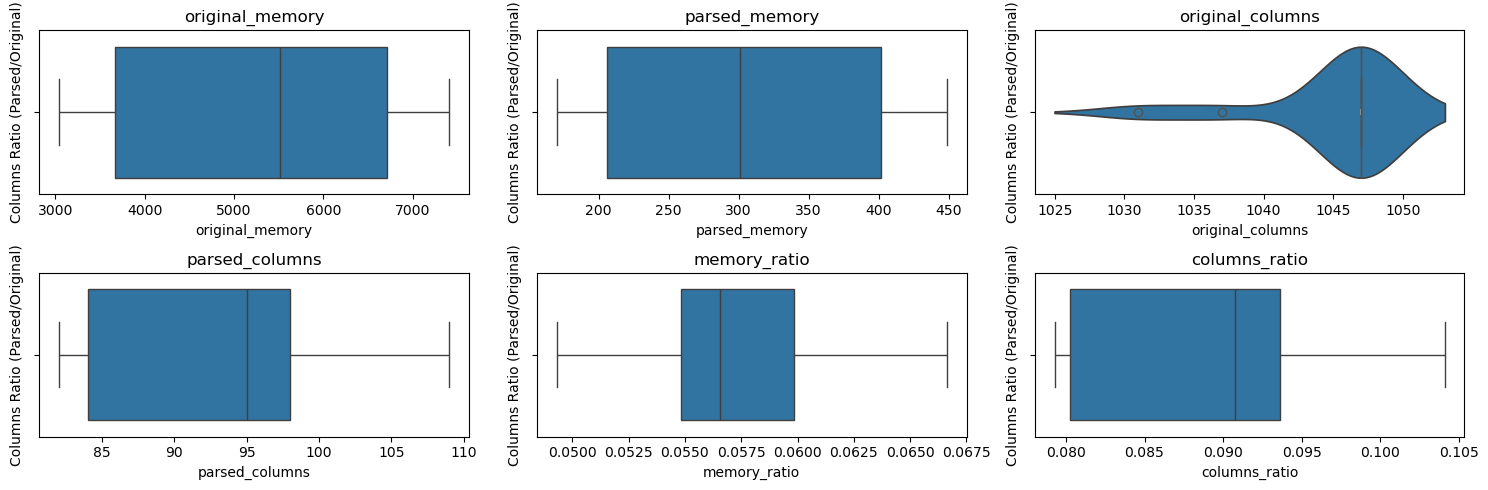

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

metrics = ['original_memory', 'parsed_memory', 'original_columns', 'parsed_columns', 'memory_ratio', 'columns_ratio']

for ax, metric in zip(axes.flatten(), metrics):
    if metric == 'original_columns':
        sb.violinplot(x=preprocessing_metrics_df_copy[metric], ax=ax)
        ax.set_title(metric)
        ax.set_ylabel(y_label)
    sb.boxplot(x=preprocessing_metrics_df_copy[metric], ax=ax)
    ax.set_title(metric)
    ax.set_ylabel(y_label)
    
        

plt.tight_layout()
plt.show()

In [182]:
pkl_files = glob.glob(os.path.join('parsed_data', '*.pkl'))
shared_columns = {}
# Create a plot for each file
for pkl_file in pkl_files:
    df = pd.read_pickle(pkl_file)
    # Find shared columns
    if not shared_columns:
        shared_columns = set(df.columns)
    else:
        shared_columns &= set(df.columns)
print(f'{shared_columns}\n are shared with all flights')
print(f'other columns may have static information and be deleted')
print(f'the total amount of shared columns is {len(shared_columns)}')


{'Ios_FlightAssistance_SideSpeed_Enabled', 'Cls_MainState', 'Aerofly_Out_Aircraft_Height', 'Aerofly_Out_Aircraft_FuelMass', 'Aerofly_Out_Aircraft_Altitude', 'Aerofly_Out_Aircraft_Gravity', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo1Pressure', 'Aerofly_Out_Instrument_EngineNP', 'Aerofly_Out_Aircraft_GroundSpeed', 'Ios_Weight_Fuel', 'Ios_FlightAssistance_Throttle_Enabled', 'Aerofly_Out_Aircraft_AngleOfAttack', 'Aerofly_Out_Aircraft_Hydraulics_MainLinePressure', 'Aerofly_Out_Aircraft_Hydraulics_MainRotorServo0Pressure', 'Aerofly_Out_Instrument_EngineTorqueFraction', 'Aerofly_Out_Aircraft_TrueAirspeed', 'Aerofly_In_Aircraft_WindShearX', 'Aerofly_Out_Aircraft_MagneticHeading', 'MotionPlatform_Running', 'Aerofly_Out_Aircraft_Acceleration', 'Aerofly_Out_Aircraft_SideSlip', 'Ios_FlightAssistance_ClimbRate_Enabled', 'Aerofly_Out_Aircraft_Hydraulics_TailRotorActuatorPressure', 'MotionPlatform_FsmState', 'Aerofly_Out_Aircraft_TrueHeading', 'Aerofly_Out_Simulation_SelectedTriangles', 'Aerofly

In [195]:
pkl_files = glob.glob(os.path.join('parsed_data', '*.pkl'))
column_count = {}
# Create a plot for each file
for pkl_file in pkl_files:
    df = pd.read_pickle(pkl_file)
    for col in df.columns:
        if col in column_count:
            column_count[col] += 1
        else:
            # If it's not, add it to the dictionary with a count of 1
            column_count[col] = 1
# Print the length of all columns with count > 13
print(f'counted {len([col for col, count in column_count.items() if count >= 13])} cols with count >= 13, this should be the same as len of shared_columns {len(shared_columns)}')

counted 63 cols with count >= 13, this should be the same as len of shared_columns 63


/tmp/ipykernel_61981/1966537411.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Count', y='Column', data=filtered_column_count_df, palette='viridis')


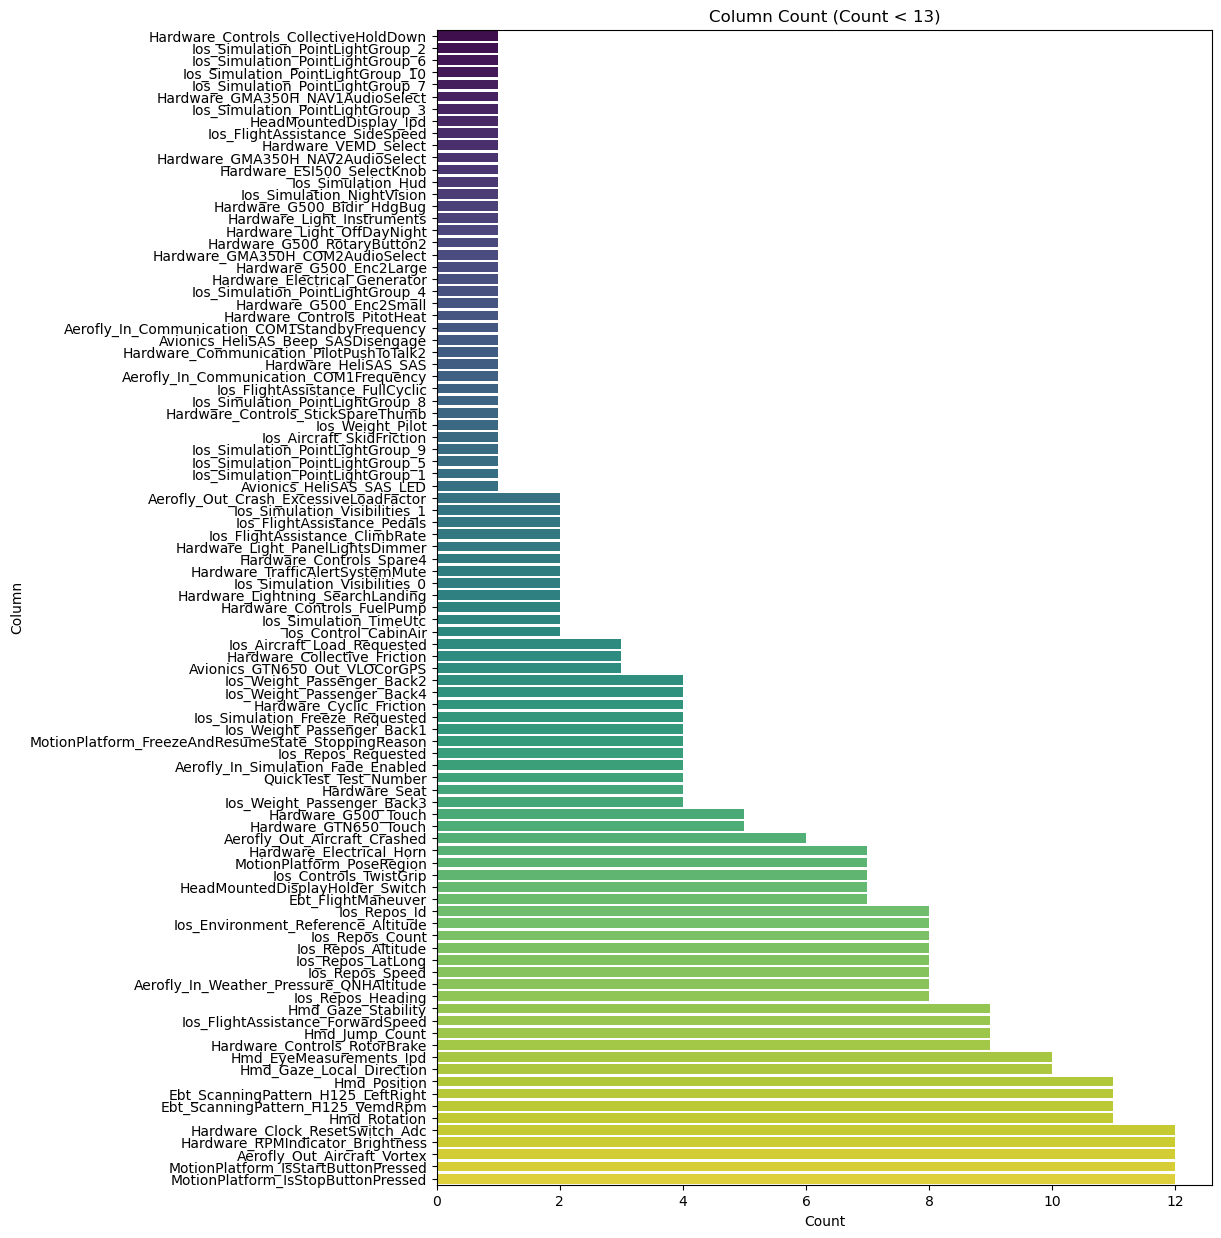

In [196]:
# Filter the column_count dictionary to get only columns where count < 13
filtered_columns = {col: count for col, count in column_count.items() if count < 13}

# Convert the filtered dictionary to a DataFrame for easier plotting
filtered_column_count_df = pd.DataFrame(list(filtered_columns.items()), columns=['Column', 'Count'])

# Sort the DataFrame by 'Count' in ascending order
filtered_column_count_df = filtered_column_count_df.sort_values(by='Count', ascending=True)

# Create a bar plot
plt.figure(figsize=(10, 15))
sb.barplot(x='Count', y='Column', data=filtered_column_count_df, palette='viridis')
plt.title('Column Count (Count < 13)')
plt.xlabel('Count')
plt.ylabel('Column')
plt.show()

# Printing Flight Data (Altitude)

In [201]:
debug_df = pd.read_pickle('parsed_data/0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79.pkl')
print(debug_df['maneuver'].dtype)
print(debug_df['maneuver'].cat.categories.tolist())

category
[3, 5, 0, 1, 6, 2, 4]


Read JSON from parsed_data/maneuver_map.json: {'Hover': 0, 'Left turn': 1, 'Straight and level': 2, 'Climb': 3, 'no maneuver': 4, 'Descent': 5, 'Right turn': 6, 'Autorotation': 7}


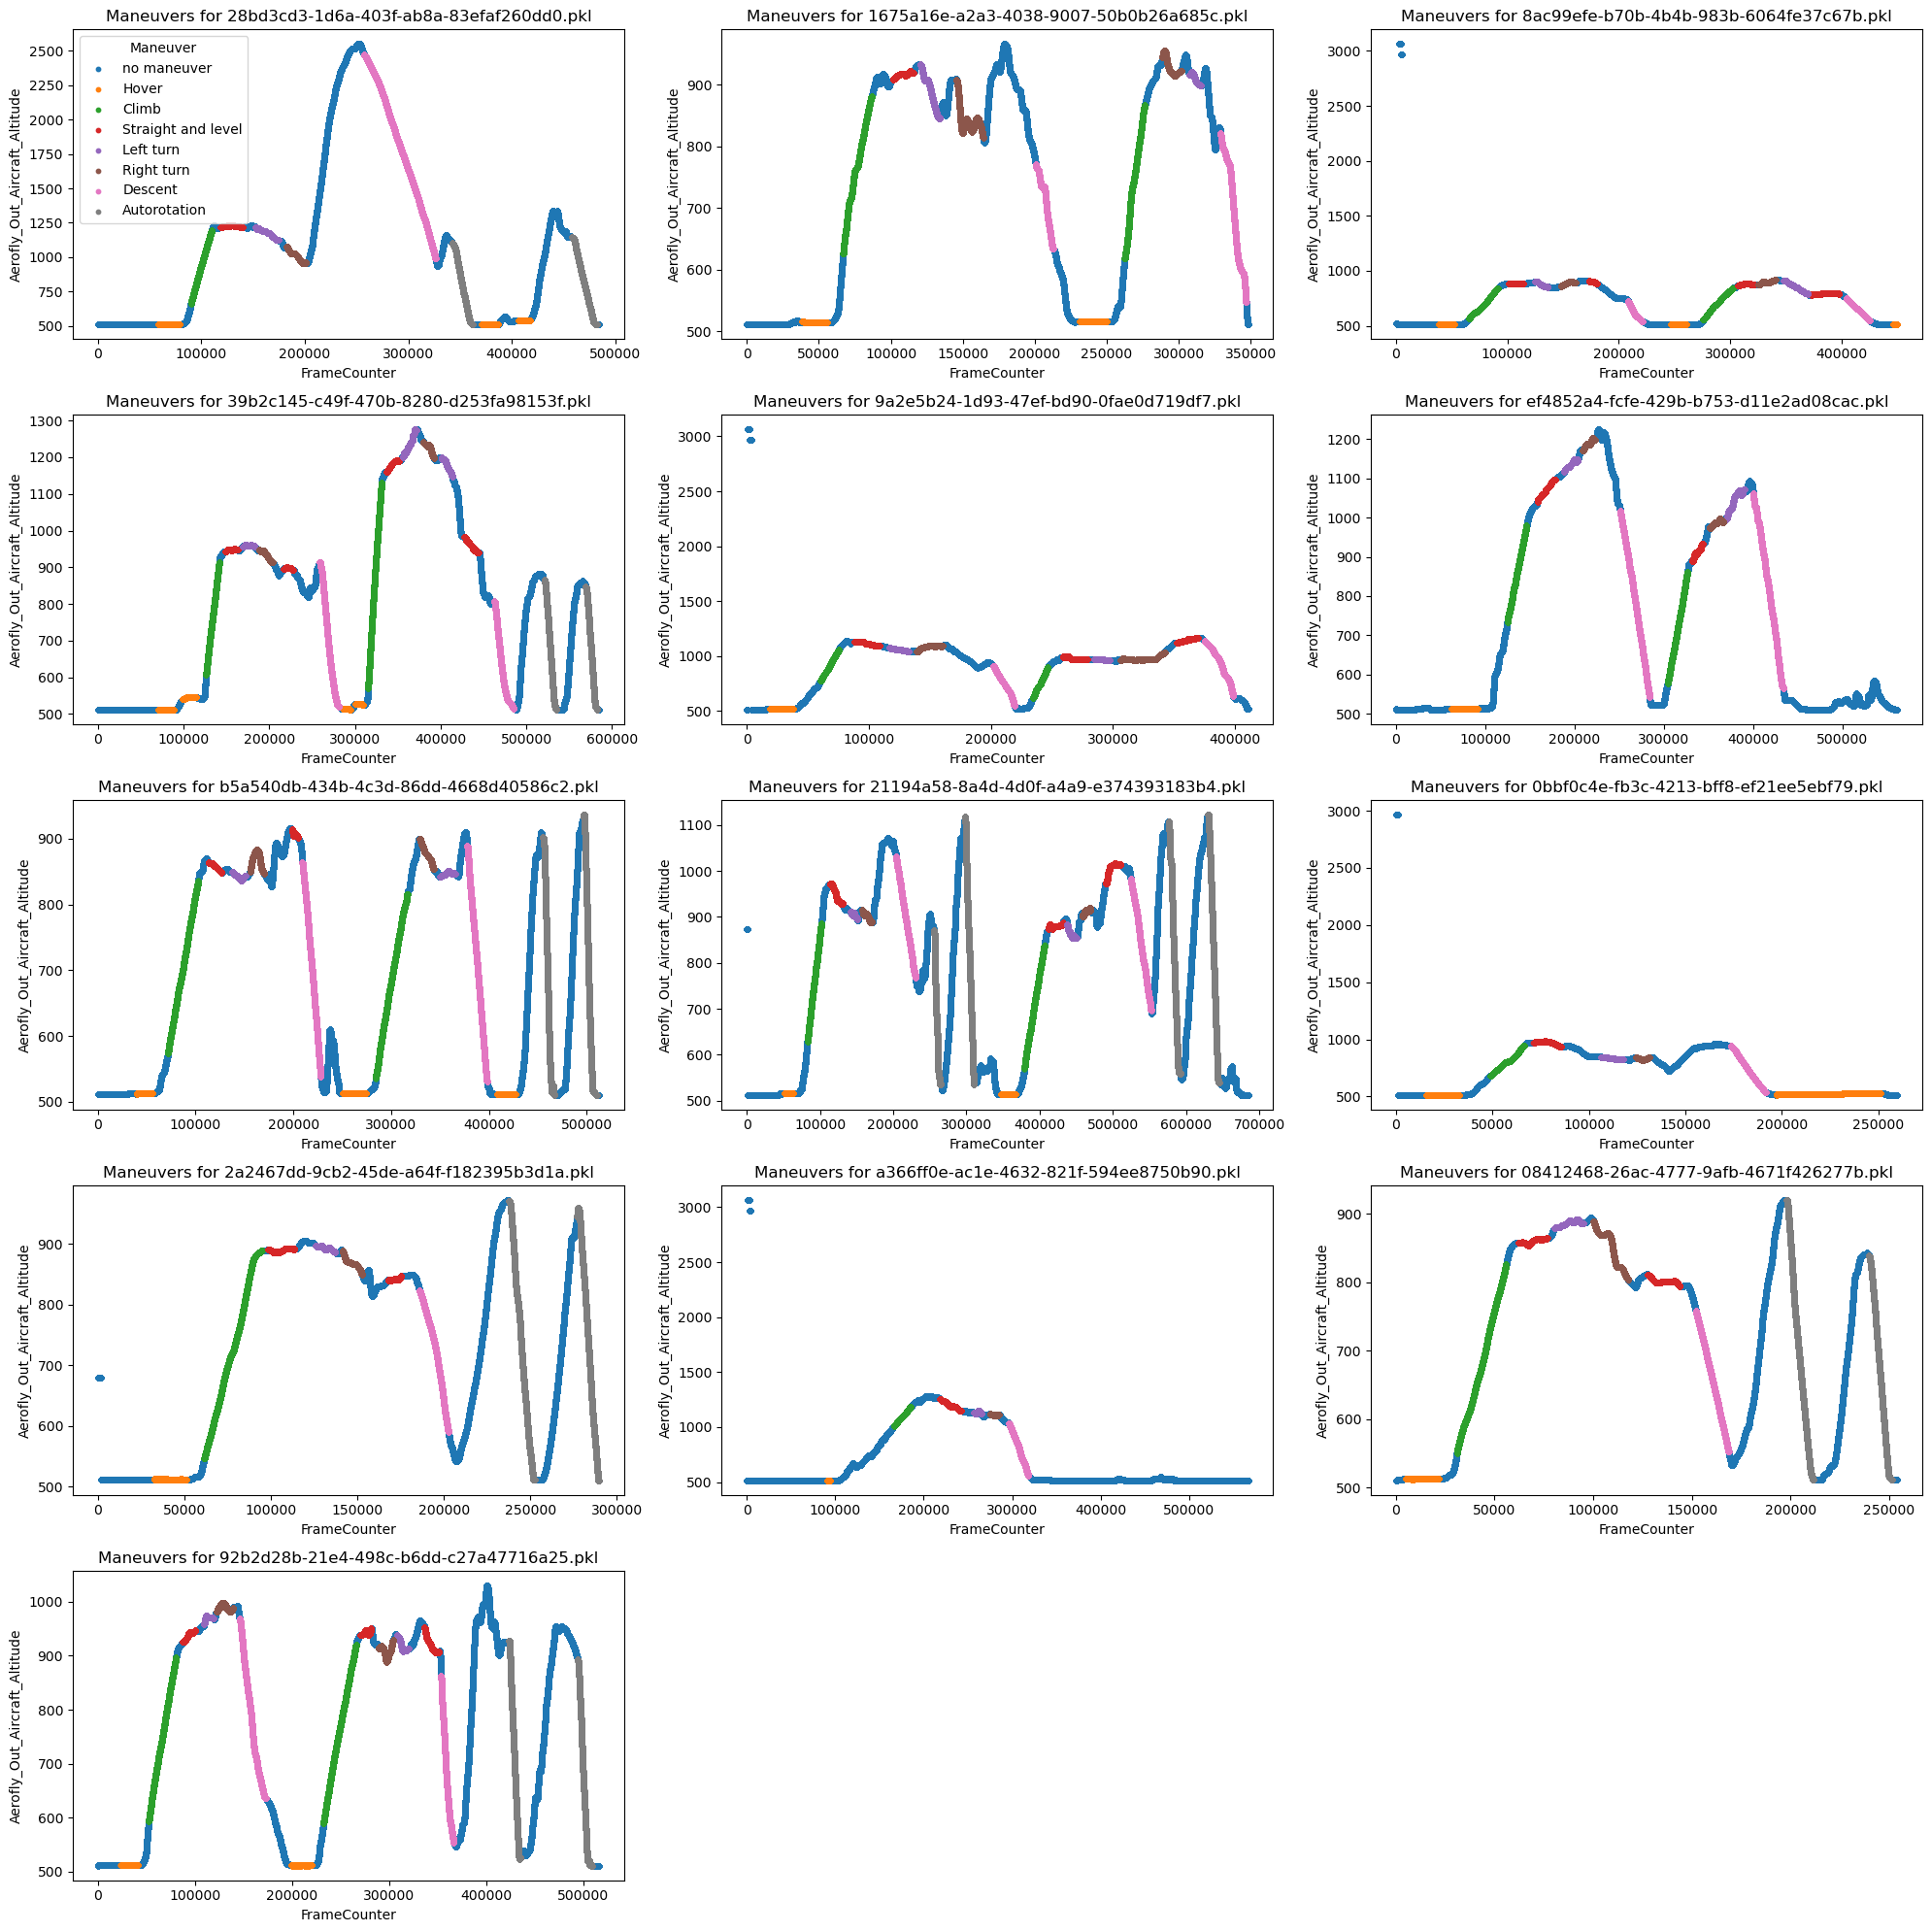

In [207]:
def plot_maneuvers(df, ax, maneuver_map, add_legend=False):
    # Reverse the maneuver_map to get a mapping from integers to strings
    reverse_maneuver_map = {v: k for k, v in maneuver_map.items()}

    # Create a scatter plot with points colored by maneuver
    for maneuver in df['maneuver'].unique():
        maneuver_data = df[df['maneuver'] == maneuver]
        ax.scatter(maneuver_data.index.get_level_values('FrameCounter'), maneuver_data['Aerofly_Out_Aircraft_Altitude'], label=reverse_maneuver_map.get(maneuver, f'{maneuver}'), s=10)

    # Add labels
    ax.set_xlabel('FrameCounter')
    ax.set_ylabel('Aerofly_Out_Aircraft_Altitude')
    
    # Add legend only if specified
    if add_legend:
        ax.legend(title='Maneuver')

fig, axes = plt.subplots(5, 3, figsize=(20, 20))
axes = axes.flatten()
maneuver_map = read_maneuver_map("parsed_data/maneuver_map.json", debug=True)

for i, (ax, pkl_file) in enumerate(zip(axes, pkl_files)):
    df = pd.read_pickle(pkl_file)
    plot_maneuvers(df, ax, maneuver_map, add_legend=(i == 0))
    ax.set_title(f'Maneuvers for {os.path.basename(pkl_file)}')

# Hide any unused subplots
for ax in axes[len(pkl_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()